# I - Overview of the SCAN-B Follow-up cohort (2010-2018)

## 1. Set-up and data import

In [38]:
# import 
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
#from matplotlib_venn import venn3
from venn import venn

In [5]:
# set wd
os.chdir(os.path.expanduser("~/PhD_Workspace/PredictRecurrence/"))

In [6]:
!ls -lh ./data/standardized/

total 3717984
-rw-r--r--  1 le7524ho  staff   4.9K Mar 10 15:41 SCANB_DNAmethylation.csv
-rw-r--r--  1 le7524ho  staff   1.6G Mar 10 15:40 SCANB_RNAseq_expression.csv
-rw-r--r--  1 le7524ho  staff   170M Mar 10 15:41 SCANB_RNAseq_mutations.csv
-rw-r--r--  1 le7524ho  staff   757K Mar 10 15:39 SCANB_clinical.csv
-rw-r--r--  1 le7524ho  staff   117K Mar 10 15:39 SCANB_sample_modalities.csv


In [7]:
# input paths
infile_1 = "./data/standardized/SCANB_sample_modalities.csv"
infile_2 = "./data/standardized/SCANB_clinical.csv"
infile_3 = "./data/standardized/SCANB_RNAseq_expression.csv"
infile_4 = "./data/standardized/SCANB_RNAseq_mutations.csv"
infile_5 = "./data/standardized/SCANB_DNAmethylation.csv"

In [8]:
# read in data
sample_modalities = pd.read_csv(infile_1)
clinical = pd.read_csv(infile_2)
RNAseq_expr = pd.read_csv(infile_3)
RNAseq_mut = pd.read_csv(infile_4)
DNAmethyl = pd.read_csv(infile_5)
DNAmethyl.columns = ["Sample"] # until the real data is loaded

## 2. ER and HER2 status in SCAN-B


In [9]:
group_order = ["ER+HER2-", "ER+HER2+", "ER-HER2+", "TNBC", "Other"]

# Step 1: Count the occurrences of each group and reorder based on 'group_order'
group_counts = clinical['Group'].value_counts()[group_order]

# Step 2: Convert the Series into a DataFrame and rename the count column as 'Count'
group_counts_df = group_counts.reset_index(name='Count')

# Step 3: Add a new column 'Percentage' and calculate the percentage for each group
group_counts_df = group_counts_df.assign(
    Percentage=lambda x: (x['Count'] / x['Count'].sum()) * 100
)

# Step 4: Round the 'Percentage' column to 0 decimal places
group_counts_df = group_counts_df.round({'Percentage': 0})

# Step 5: Rename the 'index' column to 'Group'
group_counts_df = group_counts_df.rename(columns={'index': 'Group'})

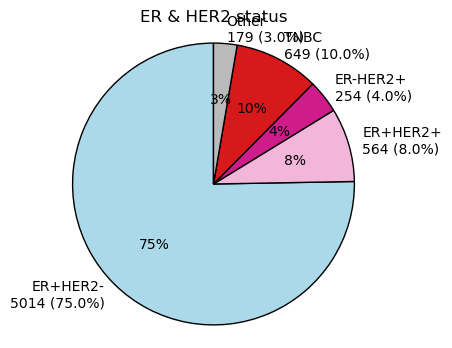

In [10]:
# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(group_counts_df['Count'], 
        labels=group_counts_df['Group'] + '\n' + group_counts_df['Count'].astype(str) + ' (' + group_counts_df['Percentage'].astype(str) + '%)', 
        autopct='%1.0f%%', 
        colors=['#abd9e9', '#f1b6da', '#d01c8b', '#d7191c', '#bababa'], 
        startangle=90, 
        wedgeprops={'edgecolor': 'black'})

# Title and aesthetics
plt.title('ER & HER2 status')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

## 3. Sample sets with available data modalities

### In the whole SCAN-B cohort

In [105]:
sample_modalities.head()

,Sample,clinical,RNAseq_expression,RNAseq_mutations,DNAmethylation
0,S000001,1,1,1,0
1,S000002,1,1,1,0
2,S000006,1,1,1,1
3,S000008,1,1,1,0
4,S000011,1,1,1,0


In [17]:
# Create a list of sample groups based on conditions in the DataFrame
venn_dict = {
    #"Clinical": set(sample_modalities[sample_modalities['clinical'] == 1]['Sample']),
    "DNAmethyl": set(sample_modalities[sample_modalities['DNAmethylation'] == 1]['Sample']),
    "RNAseq_mut": set(sample_modalities[sample_modalities['RNAseq_mutations'] == 1]['Sample']),
    "RNAseq_gex": set(sample_modalities[sample_modalities['RNAseq_expression'] == 1]['Sample'])
}

<Figure size 200x200 with 0 Axes>

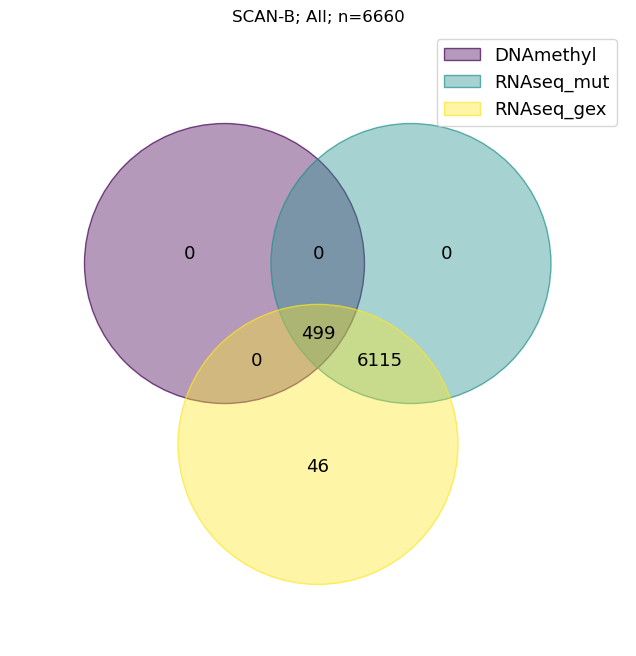

In [25]:
plt.figure(figsize=(2, 2))
venn(venn_dict)
#venn3(list(venn_dict.values()), set_labels=list(venn_dict.keys()))
plt.title(f"SCAN-B; All; n={len(sample_modalities['Sample'])}")
#plt.suptitle("With variants from RNAseq", fontsize=10,)
plt.show()

### In the ER+HER2- subset

In [26]:
clin_group = "ER+HER2-" 

# Prepare list of sample groups using a dictionary
venn_dict = {
    "DNAmethyl": set(sample_modalities['Sample'][
        (sample_modalities['DNAmethylation'] == 1) & 
        (sample_modalities['Sample'].isin(clinical['Sample'][clinical['Group'] == clin_group]))
    ]),
    "RNAseq.mut": set(sample_modalities['Sample'][
        (sample_modalities['RNAseq_mutations'] == 1) & 
        (sample_modalities['Sample'].isin(clinical['Sample'][clinical['Group'] == clin_group]))
    ]),
    "RNAseq.gex": set(sample_modalities['Sample'][
        (sample_modalities['RNAseq_expression'] == 1) & 
        (sample_modalities['Sample'].isin(clinical['Sample'][clinical['Group'] == clin_group]))
    ])
}

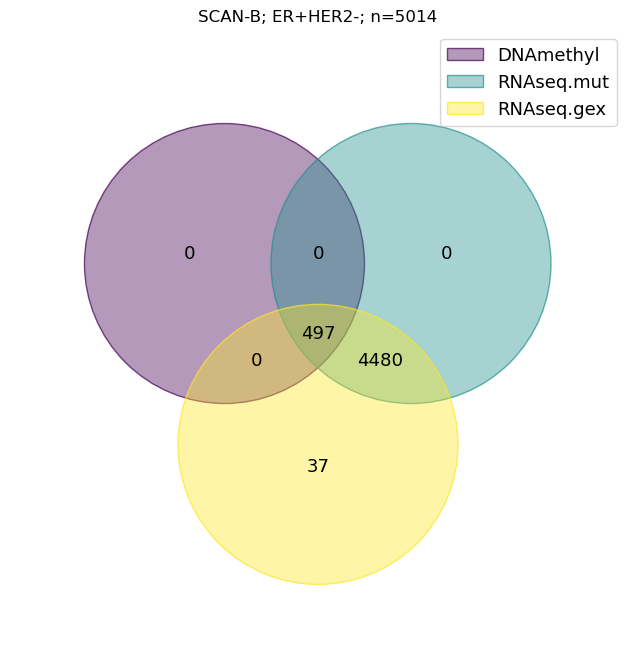

In [27]:
# Create Venn diagram
#venn3(list(venn_dict.values()), set_labels=list(venn_dict.keys()))
venn(venn_dict)

# Customizing plot
plt.title(f"SCAN-B; {clin_group}; n={len(clinical['Sample'][clinical['Group'] == clin_group])}")
#plt.subplot(111).set_title("With variants from RNAseq")

# Show the plot
plt.show()

# III - Survival analyses and Censoring distribution

# II - In-depth look into individual data types

Select subgroup for which to run the subsequent analyses:

In [ ]:
clinical_selected = clinical[clinical["Group"]=="ER+HER2-"]
#clinical_selected = clinical

## 1. Clinicopathological variables

In [49]:
print(clinical_selected.shape)
print(clinical_selected.dtypes)

(5014, 22)
Sample         object
ER             object
PR             object
HER2           object
LN.spec        object
NHG           float64
Size.mm       float64
InvCa.type     object
Age             int64
NCN.PAM50      object
DRFi_days     float64
DRFi_event    float64
OS_days       float64
OS_event      float64
RFi_days      float64
RFi_event     float64
BCFi_days     float64
BCFi_event      int64
Chemo           int64
Endo            int64
Immu            int64
Group          object
dtype: object


In [ ]:
clinical_selected.head()

,Sample,ER,PR,HER2,LN.spec,NHG,Size.mm,InvCa.type,Age,NCN.PAM50,...,OS_days,OS_event,RFi_days,RFi_event,BCFi_days,BCFi_event,Chemo,Endo,Immu,Group
0,S000001,Positive,Positive,Negative,N0,2.0,13.0,Other,85,LumA,...,3313.0,1.0,2811.0,0.0,2660.0,0,0,1,0,ER+HER2-
1,S000002,Negative,Negative,Negative,N0,3.0,16.0,Ductal,70,Basal,...,4094.0,0.0,1805.0,0.0,2665.0,0,1,0,0,TNBC
2,S000006,Positive,Negative,Negative,N0,3.0,18.0,Ductal,60,Basal,...,875.0,1.0,642.0,1.0,875.0,1,1,1,0,ER+HER2-
3,S000008,Positive,Positive,Negative,N0,2.0,9.0,Ductal,40,LumA,...,4067.0,0.0,1477.0,0.0,534.0,1,0,1,0,ER+HER2-
4,S000011,Positive,Positive,Negative,1to3,2.0,18.0,Lobular,80,LumA,...,4088.0,0.0,1892.0,0.0,2659.0,0,0,1,0,ER+HER2-


### Missing data

<Axes: >

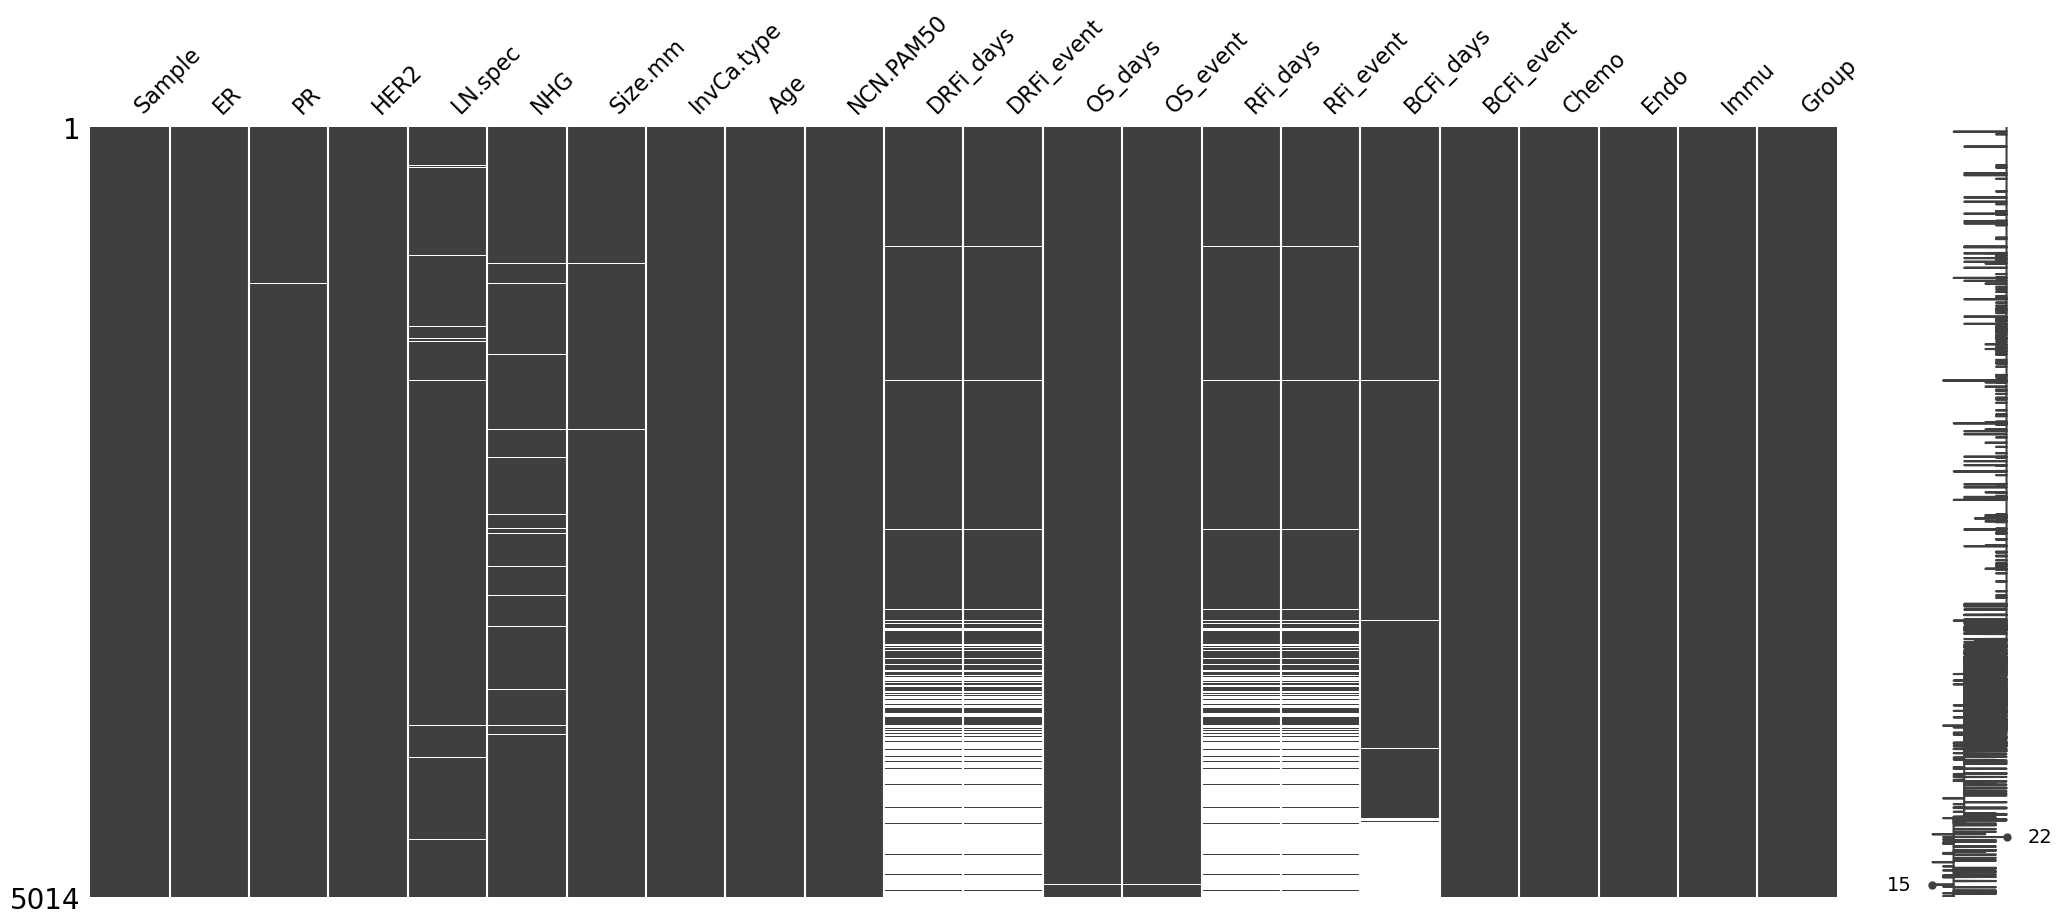

In [52]:
msno.matrix(clinical_selected)

<Axes: >

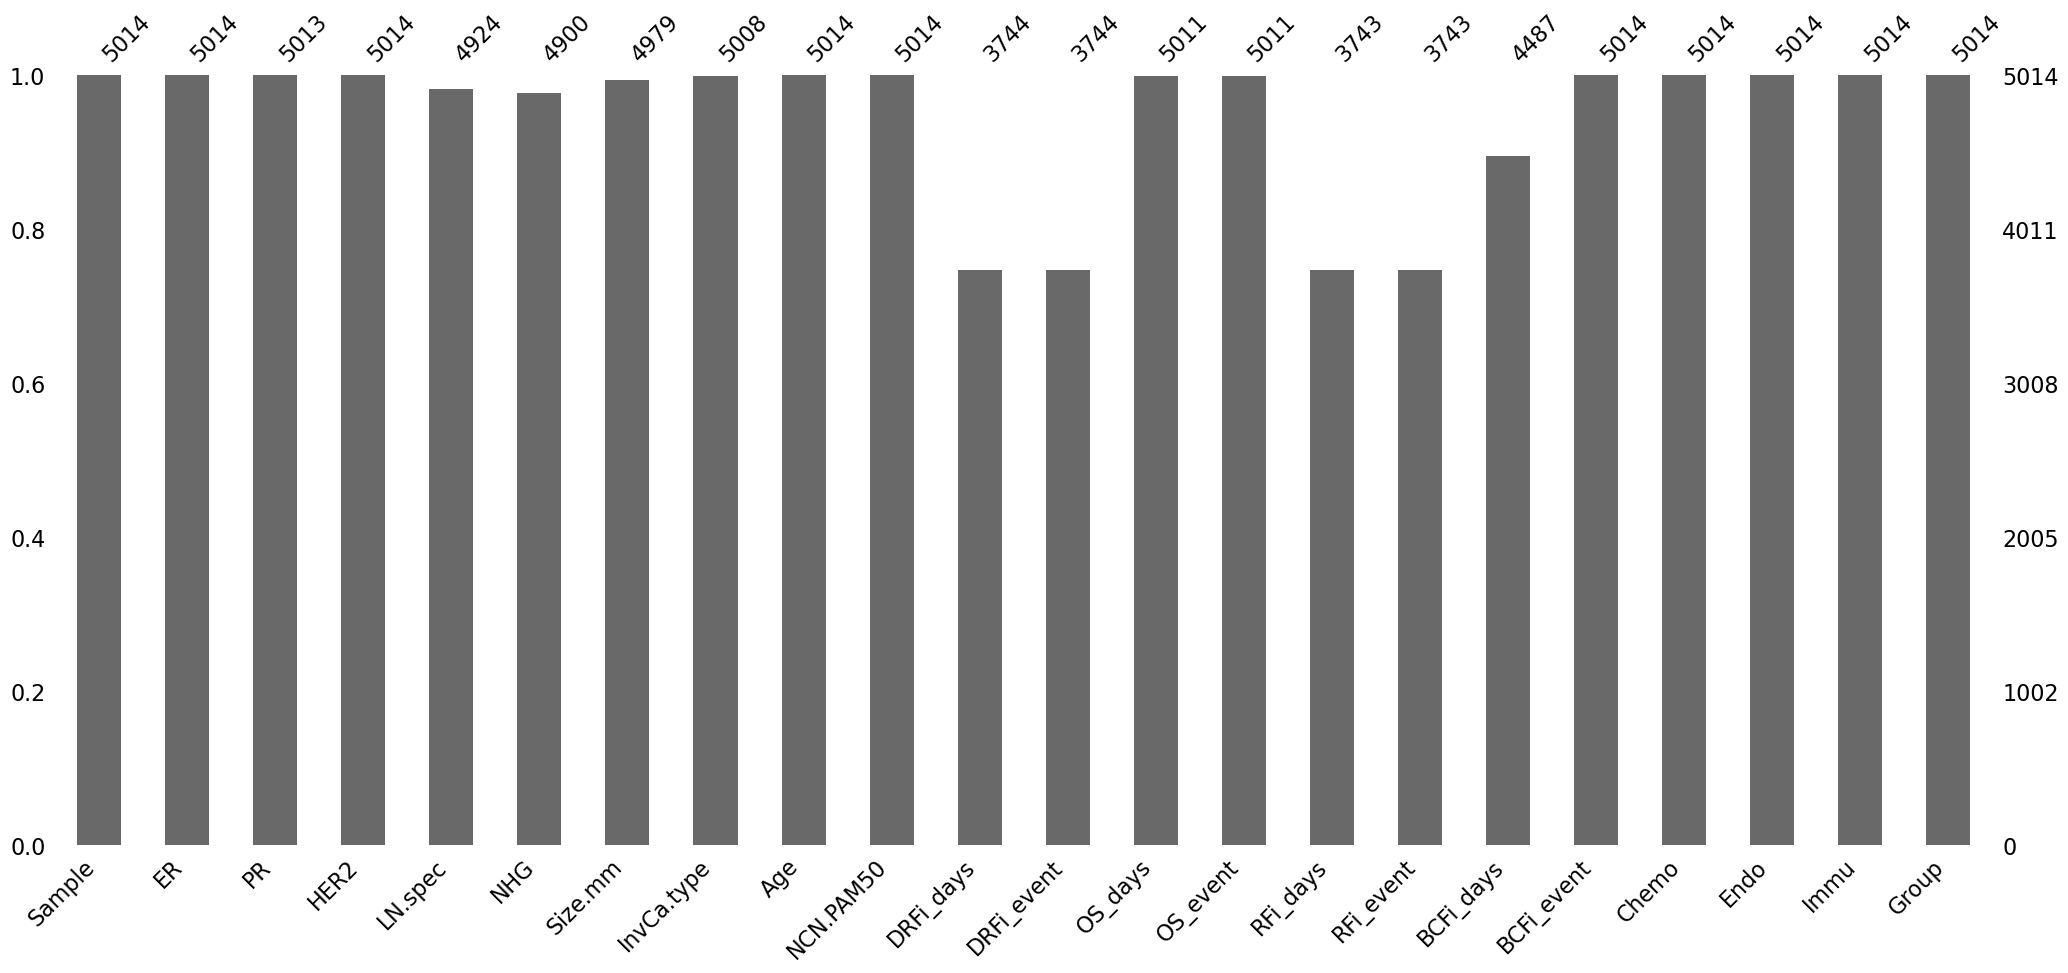

In [53]:
msno.bar(clinical_selected)

In [54]:
summary = clinical_selected.describe(include='all')  # Summary of all columns (numerical and categorical)
print(summary)

         Sample        ER        PR      HER2 LN.spec          NHG  \
count      5014      5014      5013      5014    4924  4900.000000   
unique     5014         1         2         1       4          NaN   
top     S000001  Positive  Positive  Negative      N0          NaN   
freq          1      5014      4232      5014    3065          NaN   
mean        NaN       NaN       NaN       NaN     NaN     2.021837   
std         NaN       NaN       NaN       NaN     NaN     0.649817   
min         NaN       NaN       NaN       NaN     NaN     1.000000   
25%         NaN       NaN       NaN       NaN     NaN     2.000000   
50%         NaN       NaN       NaN       NaN     NaN     2.000000   
75%         NaN       NaN       NaN       NaN     NaN     2.000000   
max         NaN       NaN       NaN       NaN     NaN     3.000000   

            Size.mm InvCa.type          Age NCN.PAM50  ...      OS_days  \
count   4979.000000       5008  5014.000000      5014  ...  5011.000000   
unique   